# Testing code for cost function "elasticity" on the annulus

In [1]:
%pylab inline

import dionysus

Populating the interactive namespace from numpy and matplotlib


## Constructing the annulus and combuting the cocycle

(-2.103912048803483,
 2.1638722015028042,
 -2.145850271465524,
 2.1641578854386467)

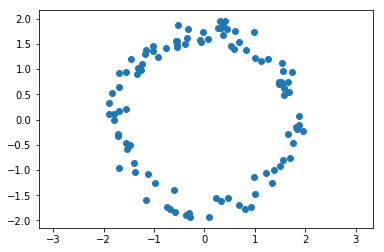

In [2]:
R = 1.5
d = .5
n = 100

# r in [0,1]
# th in [0,2pi)

from math import sin, cos, pi
from random import uniform
def rand_annulus_pt():
    r = uniform(0,1)
    th = uniform(0,2*pi)
    return (R+r*d) * cos(th), (R+r*d) * sin(th)
annulus = np.array([(rand_annulus_pt()) for x in range(100)])
plt.scatter(*annulus.T)
plt.axis('equal')

In [115]:
prime = 23
vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)

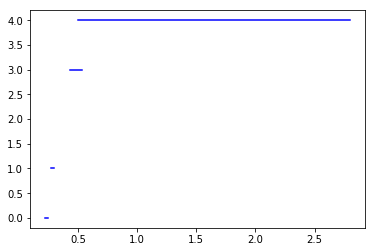

In [116]:
dionysus.plot.plot_bars(dgms[1], show=True)

In [117]:
bars = [bar for bar in dgms[1] if bar.death > 1.]
bars

[(0.498552,2.79702)]

In [118]:
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_8 = dionysus.Filtration([s for s in vr if s.data <= 1.0])
coords = [dionysus.smooth(vr_8, cocycle, prime) for cocycle in cocycles]

(-2.103912048803483,
 2.1638722015028042,
 -2.145850271465524,
 2.1641578854386467)

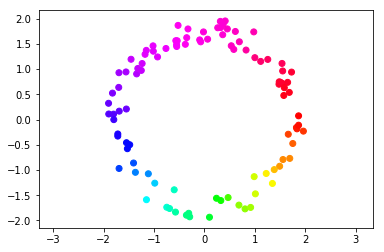

In [119]:
# subplot(121)#, projection="3d")
scatter(*annulus.T, c=coords[0], cmap="hsv")
plt.axis('equal')

# subplot(122)#, projection="3d")
# scatter(*annulus.T, c=coords[1], cmap="hsv")

# Scipy Test

In [120]:
D = {}
data = {}
indexing = {}
ix = [0]*4
thr = 3
for s in vr:
    if s.dimension() == 0:
        continue
    elif s.data > thr:
        break
    D.setdefault(s.dimension(),[[],[]])
    data.setdefault(s.dimension(),[])
    indexing.setdefault(s.dimension(),{})
    indexing.setdefault(s.dimension()-1,{})
    if not s in indexing[s.dimension()]:
        indexing[s.dimension()][s] = ix[s.dimension()]
        ix[s.dimension()] += 1
    for dat, k in enumerate(s.boundary()): 
        if not k in indexing[s.dimension()-1]:
            indexing[k.dimension()][k] = ix[k.dimension()]
            ix[k.dimension()] += 1
        D[s.dimension()][0].append(indexing[s.dimension()][s]) #rows
        D[s.dimension()][1].append(indexing[k.dimension()][k]) #cols
        data[s.dimension()].append(1. if dat % 2 == 0 else -1.)
import scipy as sp
CBd = [sp.sparse.csr_matrix((data[d], (D[d][0], D[d][1]))).todense() for d in range(1,max(D.keys())+1)]

In [121]:
from scipy.optimize import minimize

In [128]:
l2_cocycle = [0]*len(coords[0]) #reorganize the coordinates so they fit with the coboundary indices
for i, coeff in enumerate(coords[0]):
    l2_cocycle[indexing[0][dionysus.Simplex([i],0)]] = coeff
l2_cocycle = np.array(l2_cocycle)

bdry = CBd[0]

n, m = CBd[0].shape # edges X nodes

f = np.zeros((n,1)) # cocycle we need to smooth out, reorganize to fit coboundary
for c2 in cocycles[0]:
    if c2.element<(prime//2):
        f[indexing[1][vr[c2.index]]] = c2.element
    else:
        f[indexing[1][vr[c2.index]]] = c2.element-prime

## 2-norm

Derive gradient for cost function:

$$
c = \color{blue}{\|f-\delta z\|_2} + \color{green}{\lambda \|\delta z\|_2}
$$

We compute the gradient of each term separately: 

$$
\begin{align*}
\color{blue}{\left[(f-\delta z)^2\right]_j}
  &= f_j^2 - 2 f_j\sum_i \delta_{ji}z_i + \left(\sum_i \delta_{ji}z_i\right)^2 \\
\frac{\partial\|f-\delta z\|_2}{\partial z_k} 
  &= \sum_j\left[0 - 2f_j\delta_{jk}z_k + \frac{\partial}{\partial z_k}\left(\delta_{jk}^2z_k^2 + \sum_{i\neq k} 2\delta_{jk}\delta_{ji}z_kz_i\right)\right] \\
  &= \sum_j\left[-2f_j\delta_{jk}z_k + 2\delta_{jk}^2z_k + \sum_{i\neq k}2\delta_{jk}\delta_{ji}z_i\right] \\
  &= \sum_j\left[-2f_j\delta_{jk}+2\delta_{jk}\sum_i\delta_{ji}z_i\right] \\
  &= \sum_j2\delta_{jk}\left[\sum_i\delta_{ji}z_i-f_jz_k\right]
\end{align*}
$$

And

$$
\begin{align*}
\color{green}{\frac{\partial\|\left[\sum_i\delta_{ji}z_i\right]_j\|_p}{\partial z_k}}
  &= \frac{\partial}{\partial z_k}\left[\sum_j b_j^p\right]^{1/p} \\
  &= (1/p)\left[\sum_j b_j^p\right]^{1/p-1}\frac{\partial}{\partial z_k}\left[\sum_j b_j^p\right] \\
  &= \dots \\
  &= \frac{1}{\|\partial z\|_2}
  \begin{pmatrix}
  \delta_{0k} & \dots & \delta_{nk} 
  \end{pmatrix}
  \begin{pmatrix}
  b_0 \\ \vdots \\ b_n
  \end{pmatrix}
\end{align*}
$$

Combining them both into a matrix form yields

$$
\nabla cost =
\delta^T\delta z \left(2 + \frac{\lambda}{\|\delta z\|_2}\right)-2\text{diag}(z)\delta^T f
\qquad
H cost = \delta^T\delta\left(2+\frac{\lambda}{\|\delta z\|_2}\right) - 2\frac{\lambda}{\|\delta z\|_2^3}\delta^T\delta z (\delta z)^T\delta - 2 \text{diag}(\delta^T f)
$$

In [135]:
def cost(Z,L = l,F = f, B = bdry):
    return np.sum(np.square(F - B*Z.reshape(B.shape[1],1))) + L*np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)

In [136]:
l = 1.
def grad(Z,L = l,F = f, B = bdry):
    if np.linalg.norm(B*Z.reshape(B.shape[1],1),ord=2) != 0:
        coeff_A = 2 + L/np.linalg.norm(B*Z.reshape(B.shape[1],1),ord=2)
        print (coeff_A)
    else:
        coeff_A = 2
    dz = B*Z.reshape(Z.shape[0],1)
    return np.array(coeff_A * B.T * dz - 2 * B.T * F).flatten()

In [137]:
res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)

2.047795213036409
2.0671961541518713
2.060766411497749
2.060919296505767
2.061262132049825
2.06128231957949
2.061273299058348
2.0612730983662964
2.0612728724718674
2.061272776859155
2.0612728239677285


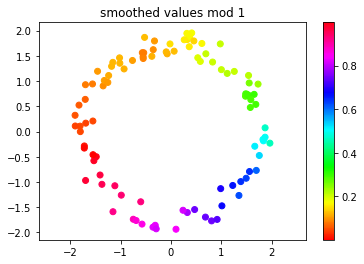

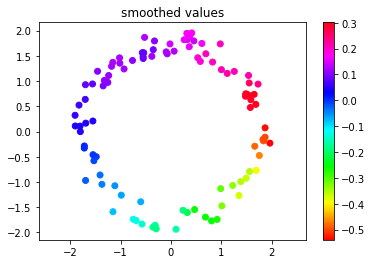

In [138]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')
plt.show()

Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = Zv.T[:,messed_ix]
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values')
plt.show()

## 1-norm

In [139]:
l = -0.
def grad(Z,L = l,F = f, B = bdry, toll = 1e-18):
    dz = B*Z.reshape(Z.shape[0],1)
    ndz = np.sign(np.where(dz<toll, 0, dz))
    return np.array(2 * B.T * dz - 2 * B.T * F + L * B.T * ndz).flatten()

In [140]:
def cost(Z,L = l,F = f, B = bdry):
    return np.sum(np.square(F - B*Z.reshape(Z.shape[0],1))) + L*np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=1)

In [141]:
res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)

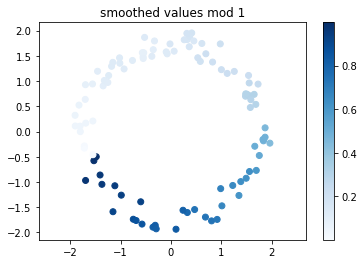

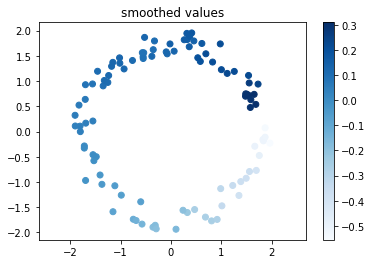

In [142]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="Blues")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')
plt.show()

Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = Zv.T[:,messed_ix]
scatter(*annulus.T, c=color[0], cmap="Blues")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values')
plt.show()